In [1]:
# In this notebook we'll go through every piece of the advanced lane finding pipeline, showing and saving the results for an 
# individual image.Then we´ll use every method defined for the individual image in the "process" method, and we'll apply it 
# to a video stream 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
# Importing images for camera calibration
images = glob.glob('./camera_cal/calibration*.jpg')

In [2]:
objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# For each calibration image we map every corner in an undistorted chessboard (objpoints) to its corresponding
# corner in the distorted image (imgpoints)
for fimg in images:
    img = cv2.imread(fimg)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)

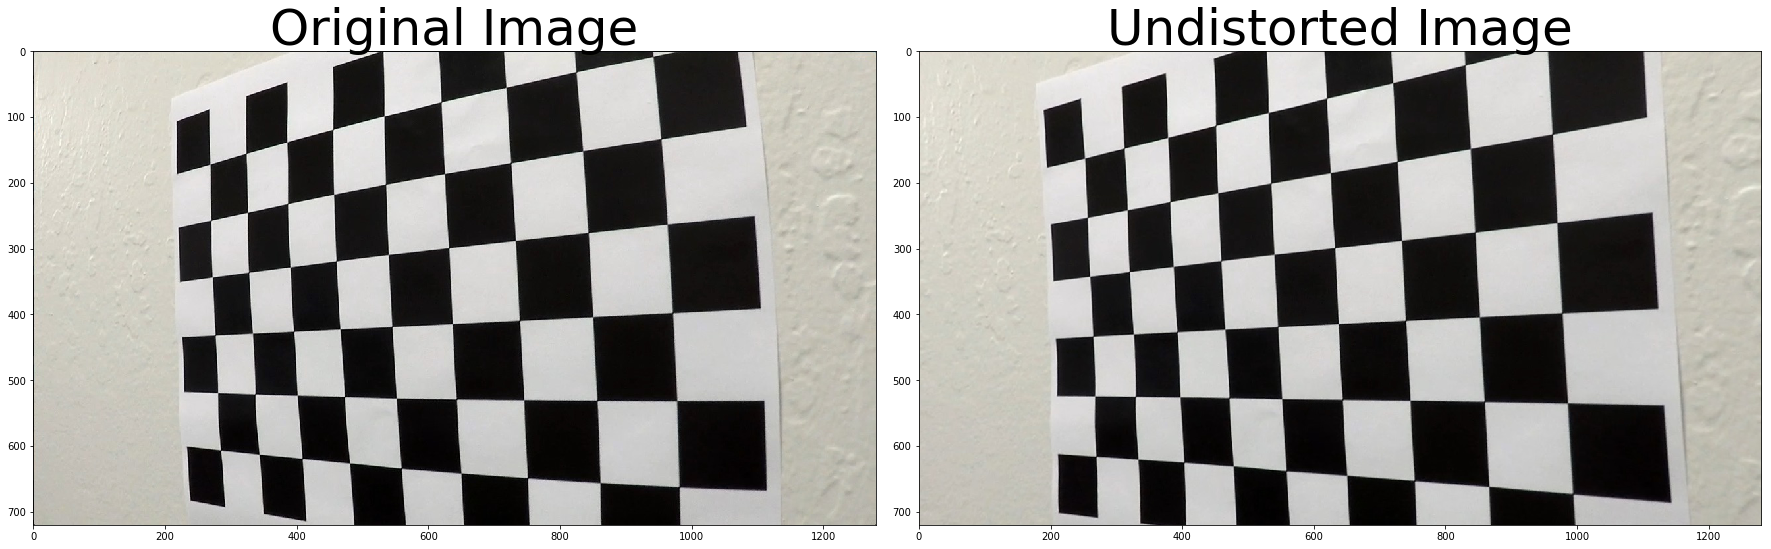

In [3]:
# Undistort image using the objpoints and imgpoints we've just collected
def undistort(img, objpoints, imgpoints, print_yn = False):
    # Cv2 camera calibration method
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Cv2 undistort method
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    if print_yn:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)        
        undistorted_to_save = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./output_images/'+ image_name + '_undistorted.jpg', undistorted_to_save)
        
    return undist

image_name = 'calibration4'
img_cal = cv2.imread('./camera_cal/' + image_name + '.jpg')
img_cal = cv2.cvtColor(img_cal, cv2.COLOR_BGR2RGB)
undistorted_cal = undistort(img_cal, objpoints, imgpoints, print_yn = True)

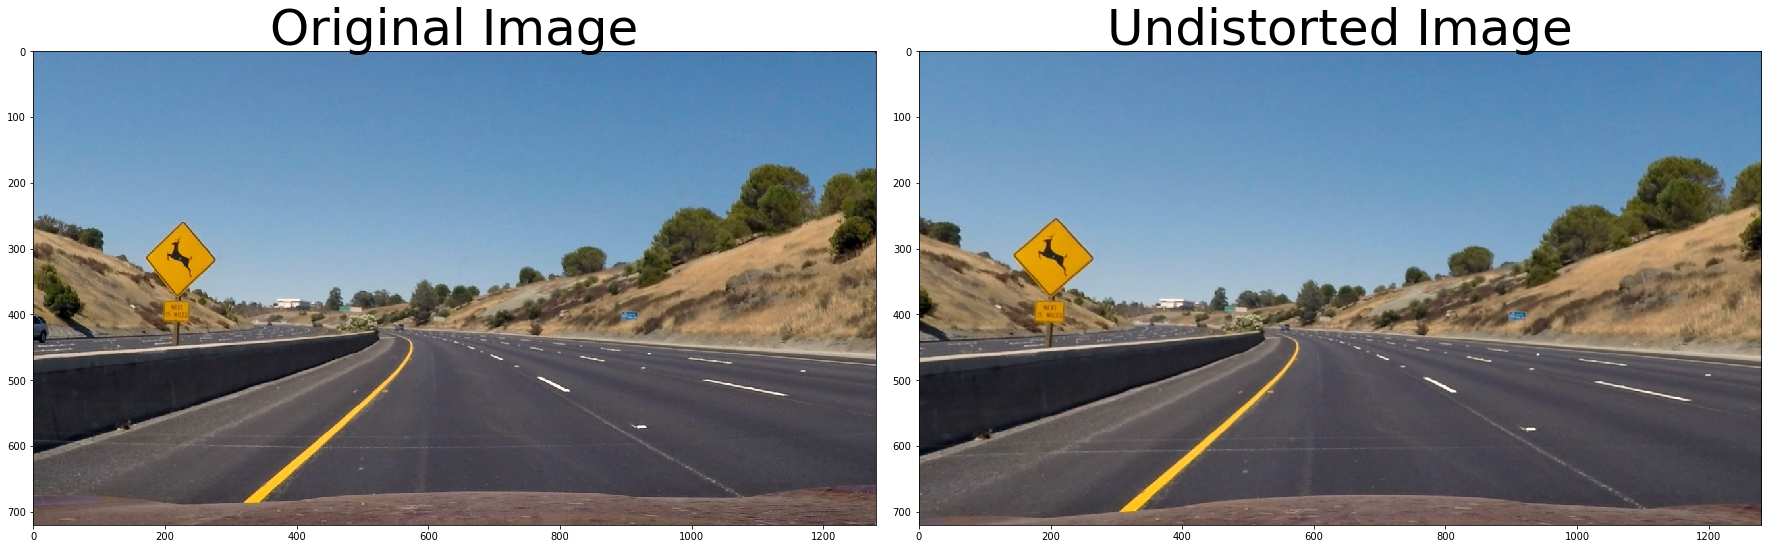

In [4]:
image_name = 'test2'
img = cv2.imread('./test_images/' + image_name + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

undistorted = undistort(img, objpoints, imgpoints, print_yn = True)

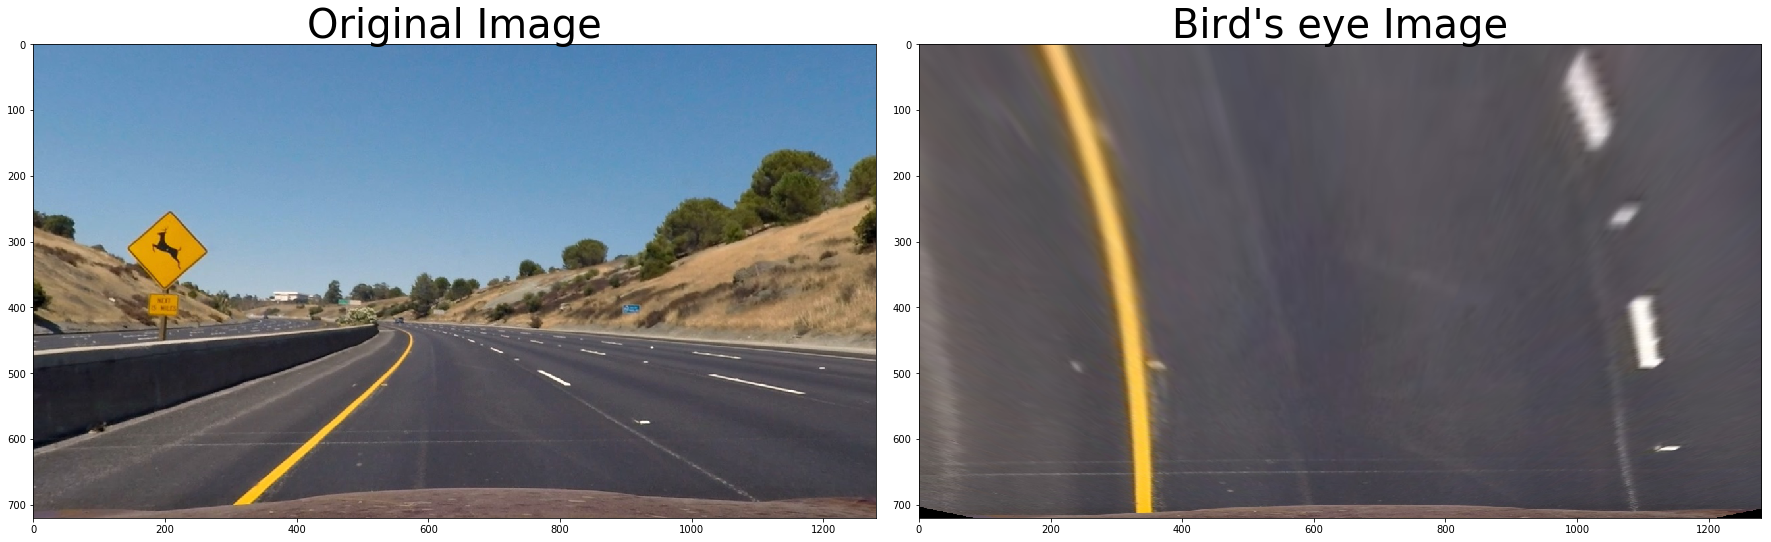

In [5]:
# After some trying some values and following some suggestions, this points we'll be used in the warp method
# Points in the src array will have their corresponding points in the dst array in the warped image 
src = np.float32([
    [580, 460],
    [700, 460],
    [1090, 720],
    [205, 720],
])

dst = np.float32([
    [260, 0],
    [1040, 0],
    [1040, 720],
    [266, 720],
])

# Warp method. It changes the perspective of the original image to a bird's eye view perspective. This will be useful
# in the next step, when we try to detect the lines and fit polynomials to them
def warp_image(undistorted_img, src, dst, print_yn = False):    
    img_size = (undistorted.shape[1], undistorted.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    binary_warped = cv2.warpPerspective(undistorted_img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if print_yn:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(undistorted)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(binary_warped)
        ax2.set_title("Bird's eye Image", fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        binary_warped_to_save = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./output_images/' + image_name + '_warped.jpg', binary_warped_to_save)

    return M, binary_warped, Minv

M, binary_warped, Minv = warp_image(undistorted, src, dst, print_yn = True)

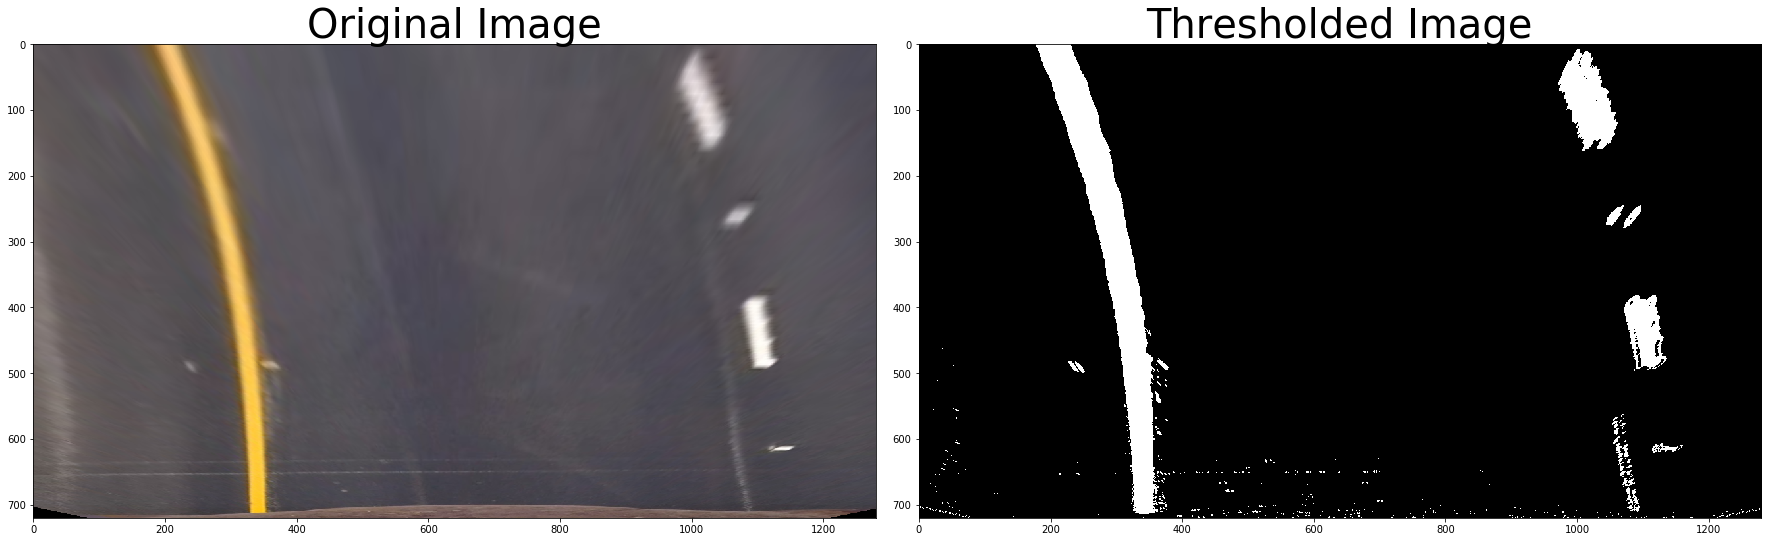

In [6]:
# Combine color and sobel thresholds to detect the lane lines
def combined_thresholds(img, sx_thresh=(20, 100), print_yn = False):
    img = np.copy(img)    
    # We'll use the hsv color space for color thresholds and the l (lightness) channel from the hls color space
    # for sobel thresholds. 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)    
    l_channel = hls[:,:,1]    
    
    # Sobel x. Threshold values were taken from the course lesson, we tried other values but these proved quite effective
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Specialized color thresholds to detect yellow lines (student's suggestion)
    yellow_min = np.array([15, 100, 120], np.uint8)
    yellow_max = np.array([80, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(hsv, yellow_min, yellow_max)
    
    # Specialized color thresholds to detect white lines (student's suggestion)
    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 30, 255], np.uint8)
    white_mask = cv2.inRange(hsv, white_min, white_max)

    # We'll mark a pixel as part of the line if either a yellow or a white pixel has been detected
    s_binary = np.zeros_like(hsv[:, :, 0])
    s_binary[((yellow_mask != 0) | (white_mask != 0))] = 1    
    
    # Combine the two filters for the output image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if print_yn:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(binary_warped)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(combined_binary, cmap= 'gray')
        ax2.set_title('Thresholded Image', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        combined_array_to_save = np.array(combined_binary*255, np.uint8)
        cv2.imwrite('./output_images/' + image_name + '_combined_binary.jpg', combined_array_to_save)
    
    return combined_binary
    
combined_binary = combined_thresholds(binary_warped, print_yn = True)

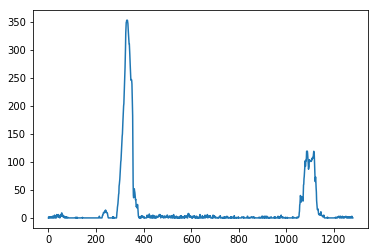

In [7]:
# We'll use histograms to find the columns where more lane line pixels have been detected. The bottom of these columns will
# be the starting point for our lines

def get_histogram(print_yn = False):
    histogram = np.sum(combined_binary[int(combined_binary.shape[0]/2):,:], axis=0)
    
    if print_yn:
        plt.plot(histogram)
        
    return histogram

histogram = get_histogram(print_yn = True)

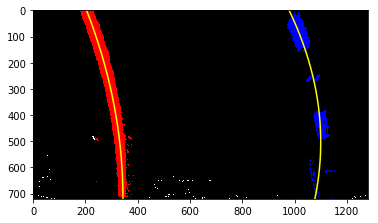

In [8]:
# With no previous clue we'll use the get_histogram method to find the starting points of our lines.
# Then we'll define a number of sliding windows to search into.
def hard_fitter(combined_binary_img, print_yn = False):
    histogram = get_histogram()
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined_binary_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary_img.shape[0] - (window+1)*window_height
        win_y_high = combined_binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if print_yn:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((combined_binary_img, combined_binary_img, combined_binary_img))*255
        # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('./output_images/'+ image_name + '_hard_fitted.jpg')
    
    return left_fit, right_fit

left_fit, right_fit = hard_fitter(combined_binary, print_yn = True)

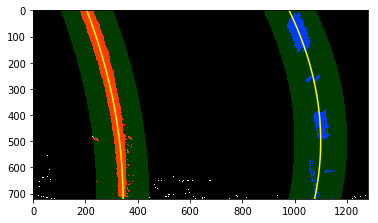

In [9]:
# Now we've detected the lines, in the next frame we can search the new lines in a window around these lines (at ~30 frames 
# per second, two consecutives images are pretty similar). In this demonstration we'll use the same image, but in a video 
# stream this would be the next image 

def soft_fitter(combined_binary_img, left_fit_in, right_fit_in, print_yn = False):
    nonzero = combined_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100

    #We'll look the new line only in an area (previous_line - margin, previous_line + margin)
    left_lane_inds = ((nonzerox > (left_fit_in[0]*(nonzeroy**2) + left_fit_in[1]*nonzeroy + left_fit_in[2] - margin)) & (nonzerox < (left_fit_in[0]*(nonzeroy**2) + left_fit_in[1]*nonzeroy + left_fit_in[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_in[0]*(nonzeroy**2) + right_fit_in[1]*nonzeroy + right_fit_in[2] - margin)) & (nonzerox < (right_fit_in[0]*(nonzeroy**2) + right_fit_in[1]*nonzeroy + right_fit_in[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if print_yn:        
        # Create an image to draw on
        out_img = np.dstack((combined_binary_img, combined_binary_img, combined_binary_img))*255
        window_img = np.dstack((combined_binary_img, combined_binary_img, combined_binary_img))*255
        
        # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image  
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,200, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,200, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('./output_images/' + image_name + '_soft_fitted.jpg')
    
    return left_fit, right_fit
    
left_fit, right_fit = soft_fitter(combined_binary, left_fit, right_fit, print_yn = True)

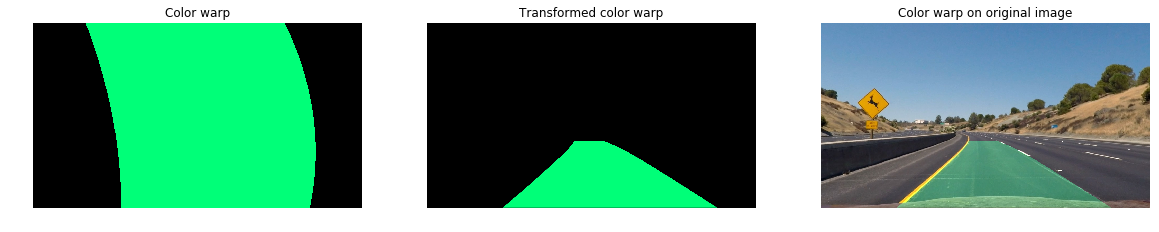

In [10]:
# We'll calculate points using the polynomials we just fitted
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Color the area defined by the detected lines, transform the perspective back to normal from bird's eye view and finally
# overlap this area over the original undistorted image
def color_area(combined_binary_img, undistorted_img, Minv_in, left_fitx_in, right_fitx_in, print_yn = False):

    out_black = np.dstack((combined_binary_img, combined_binary_img, combined_binary_img))*255
    color_warp = np.zeros_like(out_black)

    left_line = np.array([np.transpose(np.vstack([left_fitx_in, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx_in, ploty])))])
    lane_points = np.hstack((left_line, right_line))

    cv2.fillPoly(color_warp, np.int_([lane_points]), (0,255, 120))
    unwarped = cv2.warpPerspective(color_warp, Minv_in, (combined_binary_img.shape[1], combined_binary_img.shape[0])) 
    result = cv2.addWeighted(undistorted_img, 1, unwarped, 0.3, 0)
    
    if print_yn:
        plt.figure(figsize=(20,8))
        plt.subplot(1,3,1)
        plt.imshow(color_warp)
        plt.axis('off')
        plt.title('Color warp')
        plt.subplot(1,3,2)
        plt.imshow(unwarped)
        plt.title('Transformed color warp')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(result)
        plt.title('Color warp on original image')
        plt.axis('off')
        result_to_save = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./output_images/' + image_name + '_result.jpg', result_to_save)
    
    return result

result = color_area(combined_binary, undistorted, Minv, left_fitx, right_fitx, print_yn = True)

In [11]:
# These constants will be useful later to transform values from pixel space to real world space (in meters)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# In order to perform some sanity checks on the lines detected we'll define some helper functions

# Get radius of curvature
def get_curvature(left_fitx_in, right_fitx_in):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx_in*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx_in*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    avg_curverad = (left_curverad + right_curverad)/2.0
    
    return left_curverad, right_curverad, avg_curverad

left_curverad, right_curverad, avg_curverad = get_curvature(left_fitx, right_fitx)
    
print(left_curverad, 'm', right_curverad, 'm', avg_curverad, 'm')

622.189762835 m 340.497086797 m 481.343424816 m


In [12]:
# Get intercepts. Used later to find the offset from the lane center
def get_intercepts(img_in, left_fit_in, right_fit_in):
    left_intercept = left_fit_in[0]*img_in.shape[0]**2+left_fit_in[1]*img_in.shape[0]+left_fit_in[2]
    right_intercept = right_fit_in[0]*img_in.shape[0]**2+right_fit_in[1]*img_in.shape[0]+right_fit_in[2]    
    return left_intercept, right_intercept

left_intercept, right_intercept = get_intercepts(result, left_fit, right_fit)

print (left_intercept, right_intercept)

343.962544288 1076.2335911


In [13]:
image_center = (result.shape[1]/2) * xm_per_pix

# Get lane center
def get_lane_center(left_intercept_in, right_intercept_in):
    lane_center = ((right_intercept_in + left_intercept_in)/2.0) * xm_per_pix    
    return lane_center

lane_center = get_lane_center(left_intercept, right_intercept)

print (lane_center, image_center, abs(image_center - lane_center))

3.75337550067 3.382857142857143 0.37051835781


In [14]:
# We'll use just some global variables to keep track of the detections and their averages

# Reset method for global variables
def reset_globals():
    global last_five
    global skipped_frames
    global last_five_left_cur_avg
    global last_five_right_cur_avg
    global last_five_offset_avg
    last_five = []
    skipped_frames = 0
    last_five_left_cur_avg = 0
    last_five_right_cur_avg = 0
    last_five_offset_avg = 0
    
    return    

# Using the methods defined above we'll decide if a frame is good enough to help calculate the lane lines. We'll always require
# that the offset from the lane center is not too high, besides the left and right lines curvature shouldn't be too different or
# their curvature should be close to the averages

def sanity_checks(frame_dict):       
    # Left line curvature and right line curvature are not too different
    test1 = frame_dict["lcurrad"] > 0.4 * frame_dict["rcurrad"] and \
            frame_dict["lcurrad"] < 1.6 * frame_dict["rcurrad"]
    # Left and right lines curvatures are not too different from the averages
    test2a = frame_dict["lcurrad"] > 0.8 * last_five_left_cur_avg and \
             frame_dict["lcurrad"] < 1.2 * last_five_left_cur_avg
    test2b = frame_dict["rcurrad"] > 0.8 * last_five_right_cur_avg and \
             frame_dict["rcurrad"] < 1.2 * last_five_right_cur_avg
    # Offset from the lane center is not too different from the average and < 1.2m
    offset = abs(image_center - frame_dict["lcenter"])
    test3 = offset > 0.8 * last_five_offset_avg and \
            offset < 1.2 * last_five_offset_avg and \
            offset < 1.2
            
    return ((test1 or (test2a and test2b)) and test3)

# Calculate averages. We'll use them for the sanity checks and to calculate the smoothed lines that'll define the
# valid area
def get_averages(last_five_in):
    temp_sum_lcurrad, temp_sum_rcurrad, temp_sum_lcenter, avg_left_fitx, avg_right_fitx = 0, 0, 0, 0, 0
    for i in range(5):
        temp_sum_lcurrad += last_five[i]["lcurrad"]
        temp_sum_rcurrad += last_five[i]["rcurrad"]
        temp_sum_lcenter += last_five[i]["lcenter"]        
        avg_left_fitx += last_five_in[i]["lfitx"]
        avg_right_fitx += last_five_in[i]["rfitx"]

    last_five_left_cur_avg = temp_sum_lcurrad/5.0
    last_five_right_cur_avg = temp_sum_rcurrad/5.0
    last_five_offset_avg = abs(image_center - (temp_sum_lcenter/5.0))
    avg_left_fitx = avg_left_fitx/5.0
    avg_right_fitx = avg_right_fitx/5.0
    
    return last_five_left_cur_avg, last_five_right_cur_avg, last_five_offset_avg, avg_left_fitx, avg_right_fitx

In [15]:
# Image processing pipeline

def process(image):
    global last_five
    global skipped_frames
    global last_five_left_cur_avg
    global last_five_right_cur_avg
    global last_five_offset_avg
    
    # Firstly we'll undistort, warp, and apply color and sobel thresholds to our input image
    undistorted = undistort(image, objpoints, imgpoints)
    M, binary_warped, Minv = warp_image(undistorted, src, dst)
    combined_binary = combined_thresholds(binary_warped)
  
    # If this is the first image of the stream or we've skipped more than 4 frames we'll try hard fitting, if not 
    # soft fitting should be enough
    if not last_five or skipped_frames > 4: 
        left_fit, right_fit = hard_fitter(combined_binary)            
    else:
        left_fit, right_fit = soft_fitter(combined_binary, last_five[-1]["lfit"], last_five[-1]["rfit"])
    
    # We'll calculate points using the polynomials we just fitted
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    
    # Calculate curvatures, intercepts and lane center
    left_curverad, right_curverad, avg_curverad = get_curvature(left_fitx, right_fitx)    
    left_intercept, right_intercept = get_intercepts(image, left_fit, right_fit)
    lane_center = get_lane_center(left_intercept, right_intercept)

    frame_dict = {
        "lfit": left_fit,
        "rfit": right_fit,
        "lfitx": left_fitx,
        "rfitx": right_fitx,
        "lcurrad": left_curverad,
        "rcurrad": right_curverad,
        "avgcurrad": avg_curverad,
        "linterc": left_intercept,
        "rinterc": right_intercept,
        "lcenter": lane_center}

    # If this is the first frame, we'll populate the five positions of the last_five array with the information 
    # of the first detection.
    if not last_five:
        for i in range(5):
            last_five.append(frame_dict)  
    else:            
        sanity_checks_passed = sanity_checks(frame_dict)

        if sanity_checks_passed:
            # If the frame passes the sanity checks we'll add it to the last_five array, deleting the oldest frame first
            del last_five[0]
            last_five.append(frame_dict)
            skipped_frames = 0
        else:
            skipped_frames += 1
    
    # Averages of current_detections in last_five array. Some frames may have been skipped, so these are not
    # necessarily the last five frames, but the last five frames that passed the sanity checks    
    last_five_left_cur_avg, last_five_right_cur_avg, last_five_offset_avg, avg_left_fitx, avg_right_fitx = get_averages(last_five)    
    
    # Finally we'll output and image combining the original undistorted image and the green area defined by the average of
    # the last five frames that passed the sanity checks
    result = color_area(combined_binary, undistorted, Minv, avg_left_fitx, avg_right_fitx)
  
    return result

In [18]:
# Video processing cell

from moviepy.editor import VideoFileClip
from IPython.display import HTML

reset_globals()
project_output = 'processed_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False, verbose = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:15<00:02,  2.26s/it]


Wall time: 47min 17s
